# Procesamiento del Lenguaje Natural II
## TP 1 - TinyGPT

Myrna Degano (a1618)

# Consigna

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

In [3]:
# Obtener trainer.py desde el repositorio para ejecutar notebook en Colab
!wget https://raw.githubusercontent.com/mdegano-fiuba/MIA_PNL2/main/TP1/trainer.py -O trainer.py

--2025-12-02 21:35:48--  https://raw.githubusercontent.com/mdegano-fiuba/MIA_PNL2/main/TP1/trainer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11143 (11K) [text/plain]
Saving to: ‘trainer.py’

trainer.py          100%[===================>]  10.88K  --.-KB/s    in 0s      

2025-12-02 21:35:49 (133 MB/s) - ‘trainer.py’ saved [11143/11143]



In [4]:
from trainer import Trainer

In [5]:
from tabulate import tabulate
import time

## Descargando el conjunto de datos

In [6]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


# Codificación basada en caracteres

In [7]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [8]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [9]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [10]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)


        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        tril = torch.tril(torch.ones(T, T, device=x.device, dtype=torch.bool))
        wei = wei.masked_fill(~tril, float('-inf'))


        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [13]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [14]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [15]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [16]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [17]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [18]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tens

Época 1 - pérdida de entrenamiento: 2.1116


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.01478: 100%|██████████| 1246/1246 [00:10<00:00, 123.85it/s]


Época 1 - pérdida de validación: 2.0488


loss 2.07683: 100%|██████████| 11246/11246 [03:14<00:00, 57.96it/s]


Época 2 - pérdida de entrenamiento: 2.0871


val_loss 2.01478: 100%|██████████| 1246/1246 [00:09<00:00, 126.95it/s]

Época 2 - pérdida de validación: 2.0488
Entrenamiento completo.


### Prueba rápida

In [19]:
generate("To be", max_new_tokens=100,use_cache=True)

'To beend hank let not hadde\nThearse sf miitt norse um not thot-\nWeuthe then to iree me whe thoulickis mon'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [20]:
# Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,   # Probabilidad de los tokens (0=greedy, 1=normal, >1=aleatorio).
    top_k: int = 10,            # Sólo se consideran los top_k tokens más probables en cada paso.
    top_p: float = 0.9,         # Sólo se consideran los tokens cuya probabilidad acumulada ≥ top_p
)-> Optional[str]:

    """
    Genera texto a partir del prompt usando:
      - Greedy decoding (temperature=0)
      - Temperature sampling
      - Top-k / Top-p sampling
    """
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):

        # Selección de tokens de entrada
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Forward pass
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]

        # Greedy decoding
        if temperature == 0.0:

            # Seleccionar siempre el token más probable
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            idx = torch.cat((idx, next_token), dim=1)
            # Pasar al siguiente token.
            continue

        # Temperature samp
        if temperature != 1.0:
            logits = logits / temperature
            # <1 → menos aleatoriedad
            # >1 → más aleatoriedad

        # top-k, top-p (filtro como Hugging Face)
        # Clonar logits para filtrar
        filtered_logits = logits.clone()

        # Top-K - Conserva solo los top_k tokens más probables.
        if top_k is not None:
            # Setear todos los logits fuera del top-k a -inf para que no tengan probabilidad tras softmax.
            topk_values, topk_indices = torch.topk(filtered_logits, top_k)
            mask = torch.ones_like(filtered_logits, dtype=torch.bool)
            mask.scatter_(1, topk_indices, False)  # False en top-k
            filtered_logits[mask] = -float('Inf')

        # Top-P
        if top_p is not None:
            # Ordenar los tokens por probabilidad descendente.
            sorted_logits, sorted_idx = torch.sort(filtered_logits, descending=True, dim=-1)
            # Calcula la probabilidad acumulada.
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            # Marcar tokens para eliminar (probabilidad acumulada excede top_p)
            sorted_mask = cumulative_probs > top_p
            # Asegurar al menos un token
            sorted_mask[..., 0] = False
            # Poner -Inf a los tokens filtrados
            sorted_logits[sorted_mask] = -float('Inf')
            # Volver a la posición original
            filtered_logits.scatter_(1, sorted_idx, sorted_logits)

        # Softmax final y muestreo
        probs = F.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [21]:
prompt = "To be"

# Escenarios
variants = [
    ("Función generate original", lambda: generate(prompt, max_new_tokens=100, use_cache=True)),
    ("Greedy", lambda: generateV2(prompt, max_new_tokens=100, use_cache=True, temperature=0.0)),
    ("Sampling con valores por default", lambda: generateV2(prompt, max_new_tokens=100, use_cache=True)),
    ("Moderadamente creativo", lambda: generateV2(prompt, max_new_tokens=100, use_cache=True, temperature=0.8, top_k=20, top_p=0.9)),
    ("Muy creativo / aleatorio", lambda: generateV2(prompt, max_new_tokens=100, use_cache=True, temperature=1.2, top_k=50, top_p=0.95))
]

# Lista para almacenar resultados
results = []

for name, func in variants:
    start = time.time()
    text = func()
    end = time.time()

    # Contar tokens
    tokens = len(encode(text))
    elapsed = end - start
    tokens_per_sec = tokens / elapsed

    results.append([
        name,
        tokens,
        f"{elapsed:.3f}",
        f"{tokens_per_sec:.2f}",
        text
    ])

headers = ["Escenario", "Tokens generados", "Tiempo (seg)", "Tokens/seg", "Salida ejemplo"]
print(tabulate(results, headers=headers, tablefmt="grid"))


+----------------------------------+--------------------+----------------+--------------+-----------------------------------------------------------------------------------------------------------+
| Escenario                        |   Tokens generados |   Tiempo (seg) |   Tokens/seg | Salida ejemplo                                                                                            |
+==================================+====================+================+==============+===========================================================================================================+
| Función generate original        |                105 |          0.352 |       298.27 | To be there.                                                                                              |
|                                  |                    |                |              |                                                                                                           |
|         

Los resultados obtenidos no son muy coherentes y es esperable debido a:

* TinyGPT es un modelo pequeño con pocos parámetros, por lo que, no es capaz de generalizar demasiado.  

* Con un dataset de las características de Shakespeare, el modelo genera texto que parece “random” o incoherente, especialmente con prompts cortos. El texto es antiguo y poético, con vocabulario y gramática distintos al inglés moderno, por lo que, el modelo puede no captar la estructura y generar combinaciones raras de palabras.  

* Al utilizar un tokenizador por caracteres, el modelo aprende carácter por carácter y por lo tanto, se le dificulta capturar palabras completas. Necesita más contexto para formar palabras coherentes.

* Con Greedy se observa que, al ser conservador, resulta repetitivo y se corta o atasca en la misma palabra.  

* La opción moderadamente creativa (T=0.8, top_k=20, top_p=0.9)	muestra texto aparentemente más fluido, que se percibe algo más natural.  

* La opción muy creativa (T=1.2, top_k=50, top_p=0.95) resulta en texto aleatorio, con saltos raros y combinaciones más incoherentes.

* Observando la tasa de generación de tokens, se ve que las opciones de generate y generateV2 con Greedy son las más rápidas.  Las otras opciones agregan pasos extra, por lo tanto, generan una menor cantidad de tokens por segundo.  La diferencia en TinyGPT es muy pequeña, pero sería más notable al generar grandes cantidades de tokens.



## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [22]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        # return None
        return self.net(x)  # salida: [B, T, n_embd]

class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        # return self.proj(x)
        # softmax sobre los expertos
        return F.softmax(self.proj(x), dim=-1)  # [B, T, num_experts]

In [23]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:

        #  Obtener pesos del Gate
        gate_weights = self.gate(x)  # [B, T, num_experts]

        # Salida de todos los expertos
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=-1)
        # expert_outputs: [B, T, n_embd, num_experts]

        # Mezclar por los pesos del gate
        gate_weights = gate_weights.unsqueeze(2)  # [B, T, 1, num_experts]
        out = (expert_outputs * gate_weights).sum(-1)  # [B, T, n_embd]

        return out

In [24]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [25]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=2, num_experts_per_token=1)

# Entrenamiento de TinyGPT‑MoE

In [26]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)


In [27]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 5

In [28]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7242: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2772: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python

Época 1 - pérdida de entrenamiento: 2.1063


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.03024: 100%|██████████| 1246/1246 [00:10<00:00, 120.63it/s]


Época 1 - pérdida de validación: 2.0335


loss 2.11919: 100%|██████████| 11246/11246 [03:38<00:00, 51.50it/s]


Época 2 - pérdida de entrenamiento: 2.1512


val_loss 2.03024: 100%|██████████| 1246/1246 [00:10<00:00, 119.46it/s]


Época 2 - pérdida de validación: 2.0335


loss 2.11680: 100%|██████████| 11246/11246 [03:33<00:00, 52.74it/s]


Época 3 - pérdida de entrenamiento: 2.0547


val_loss 2.03024: 100%|██████████| 1246/1246 [00:10<00:00, 123.51it/s]


Época 3 - pérdida de validación: 2.0335


loss 2.12494: 100%|██████████| 11246/11246 [03:33<00:00, 52.65it/s]


Época 4 - pérdida de entrenamiento: 2.0814


val_loss 2.03024: 100%|██████████| 1246/1246 [00:10<00:00, 120.95it/s]


Época 4 - pérdida de validación: 2.0335


loss 2.10235: 100%|██████████| 11246/11246 [03:33<00:00, 52.68it/s]


Época 5 - pérdida de entrenamiento: 2.1112


val_loss 2.03024: 100%|██████████| 1246/1246 [00:10<00:00, 115.53it/s]

Época 5 - pérdida de validación: 2.0335
Entrenamiento completo.


In [29]:
generate("To be", max_new_tokens=100, use_cache=True)

"To bemld eold\nmor, all sy thake at anain th;\nHer thaicce ver If whenbom hus doon!\nHitlxe\n\nSI' sare. by ha"

In [30]:
generate("There's no more to be said", max_new_tokens=100, use_cache=True)

"There's no more to be said cenarar, iold thatw\nOut rescing too! when an bult nowcen the uts, mell im?\n\nMENENIUS:\nAfore the lar"

**Comentarios**  

* Los intentos de utilizar otro **dataset** no fueron exitosos debido a la cantidad limitada de **recursos de procesamiento**.
En el modelo MoE, cada “experto” añade capas y parámetros adicionales, por lo que, aún reduciendo batch_size, block_size, y otras configuraciones, la **memoria necesaria** sigue siendo alta y superior a la disponible en el entorno de ejecución.

* Explorando el uso de un **tokenizador preentrenado** (como GPT-2 o BPE) que genere tokens por subpalabras o palabras completas, se observa que tampoco es posible **sin modificar la arquitectura del modelo**.  Los índices generados por estos tokenizers no coincidirían con las embeddings existentes, rompiendo la correspondencia necesaria y haciendo que el modelo no funcione correctamente.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [31]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

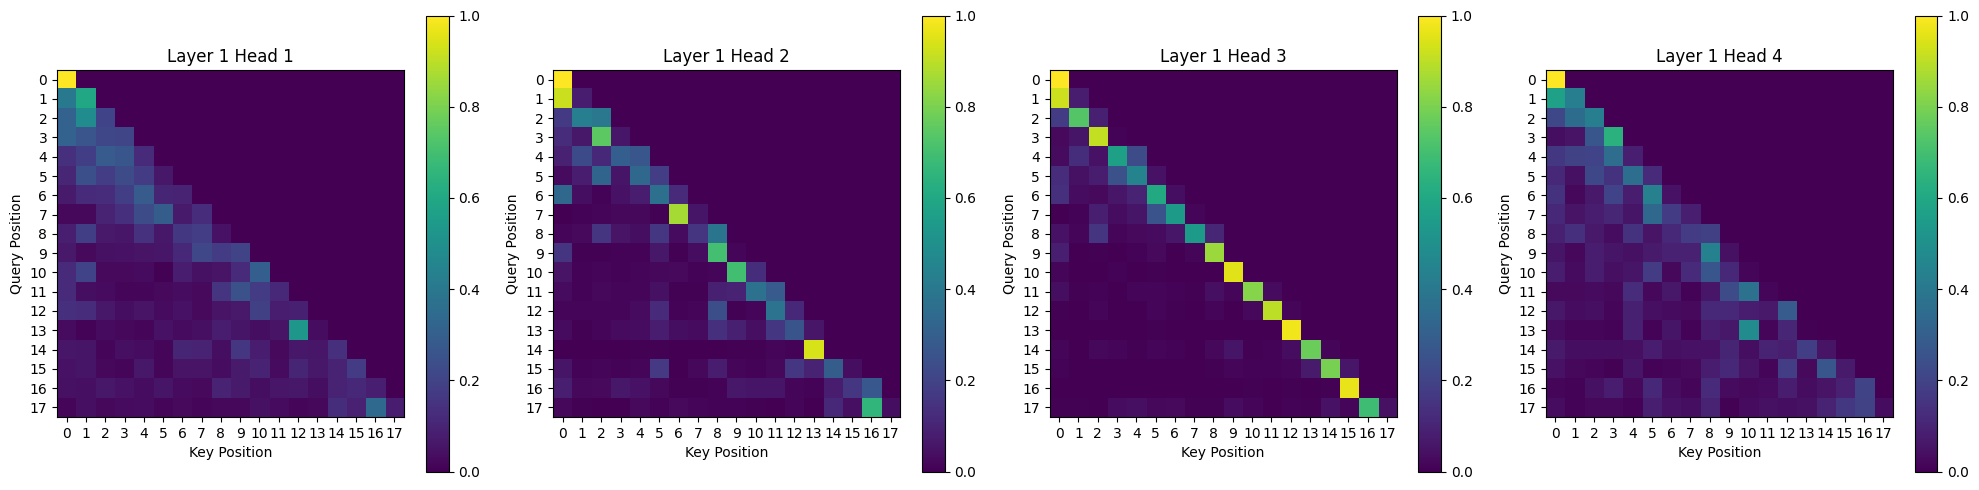

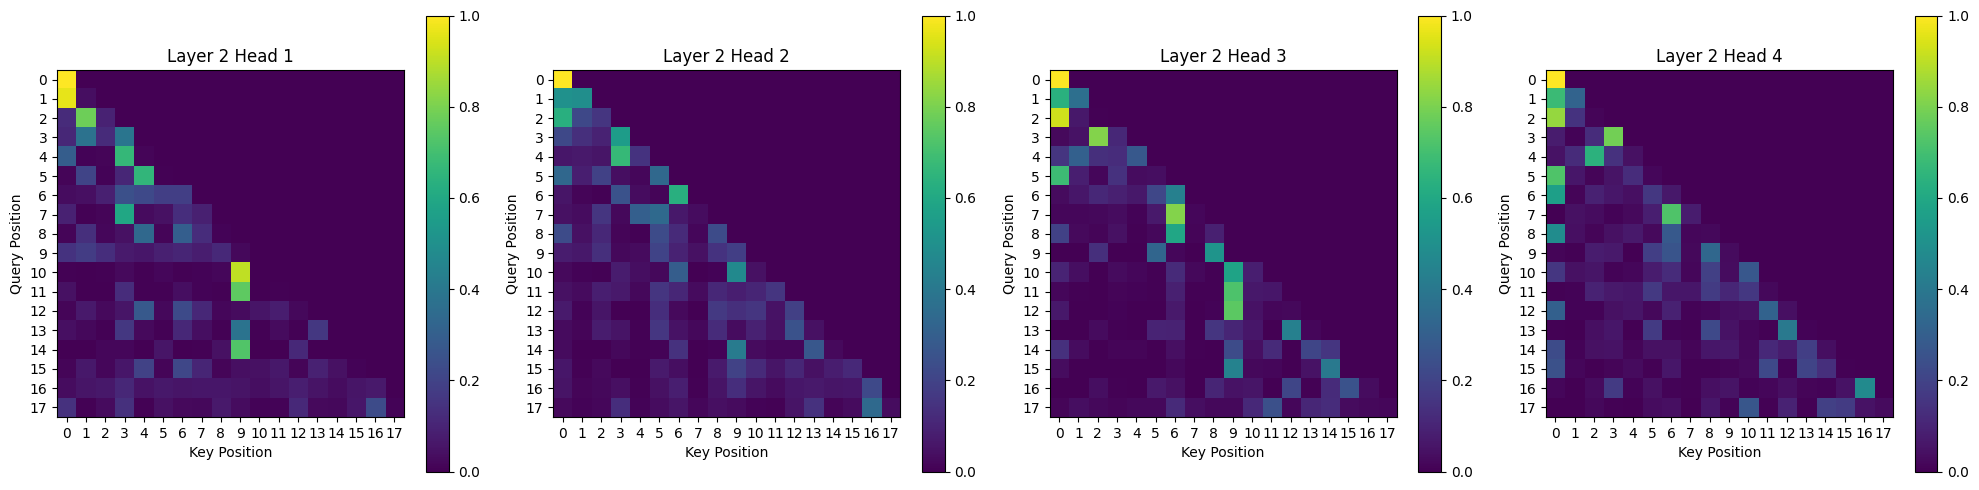

In [32]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

In [33]:
print("Número de capas:", model_moe.config.n_layer)
print("Número de cabezas por capa:", model_moe.config.n_head)


Número de capas: 2
Número de cabezas por capa: 4


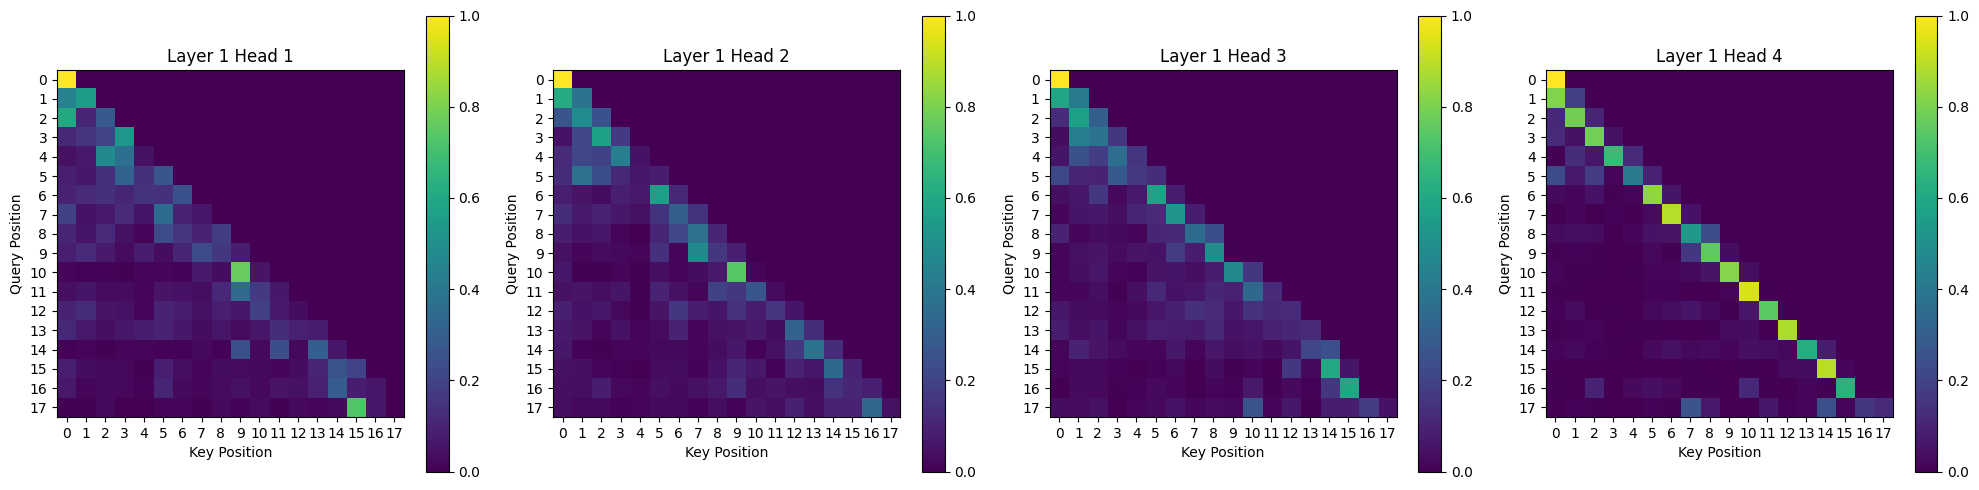

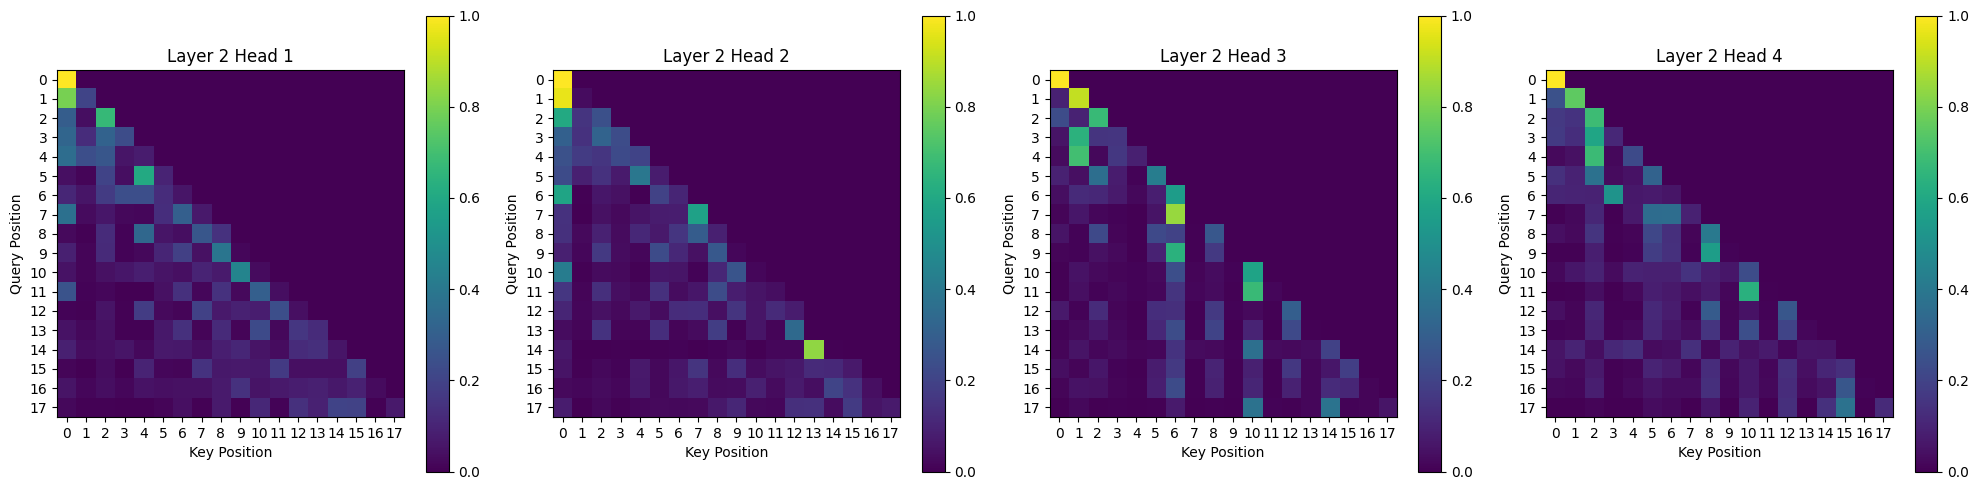

In [34]:
# Para el modelo modificado a MoE
visualize_attention(model_moe, prompt)

# Conclusiones

Las visualizaciones de atención muestran la distribución de pesos que cada cabeza de cada capa asigna a los tokens de la secuencia.   

Cada fila de figuras corresponde a una capa del modelo, y dentro de ella, cada subplot representa una de las cuatro cabezas de atención.   

Los valores de color indican cuánta “atención” presta un token (query) a otro token (key).

La distribución de colores puede interpretarse como:  
* Diagonal brillante: el token se presta atención a sí mismo o a tokens cercanos → atención local.

* Elementos fuera de la diagonal: la cabeza está capturando dependencias a otros tokens → atención global.

* Patrones verticales: muchas queries se enfocan en el mismo token → token importante para toda la secuencia.

* Patrones horizontales: un token distribuye su atención a varios tokens → contexto disperso  

Se observa que, en la primera capa, las cabezas tienden a concentrarse en tokens cercanos, reflejando atención local y capturando relaciones sintácticas inmediatas.

En la segunda capa, algunos patrones muestran atención hacia tokens más distantes, lo que sugiere que estas cabezas aprenden dependencias más globales y semánticas.

Esto es típico en Transformers donde las capas iniciales aprenden patrones locales y capas superiores capturan información más abstracta.

Las diferencias entre las cabezas indican que cada una puede especializarse en distintos patrones de relación entre tokens, aunque la especialización es limitada debido al tamaño reducido del dataset y al tokenizador por caracteres.

Aunque no se trate de un ejemplo más complejo que permita una análisis a mayor profundidad, en conjunto, estas gráficas permiten comprender cómo el modelo entrenado reparte su atención.

# ¡Felicitaciones! 🎉

Después de completar las tareas has preentrenado satisfactoriamente para fi... ¡Ahora puedes presumir ante tus amigos sobre cómo funcionan los LLM y los GPT!